# Clustering with dynamic time warping

### Special libraries
- Dynamic time warping: https://github.com/wannesm/dtaidistance
- K-medoids implementation: https://github.com/letiantian/kmedoids

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtaidistance import dtw
from dtaidistance.dtw_visualisation import plot_warping
import kmedoids

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Load data

In [3]:
air_reserve = pd.read_csv('../../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../../data_files/store_id_relation.csv')

In [4]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [17]:
locations = air_visit_data['air_store_id'].unique()
len(locations)

829

### Time warp path example

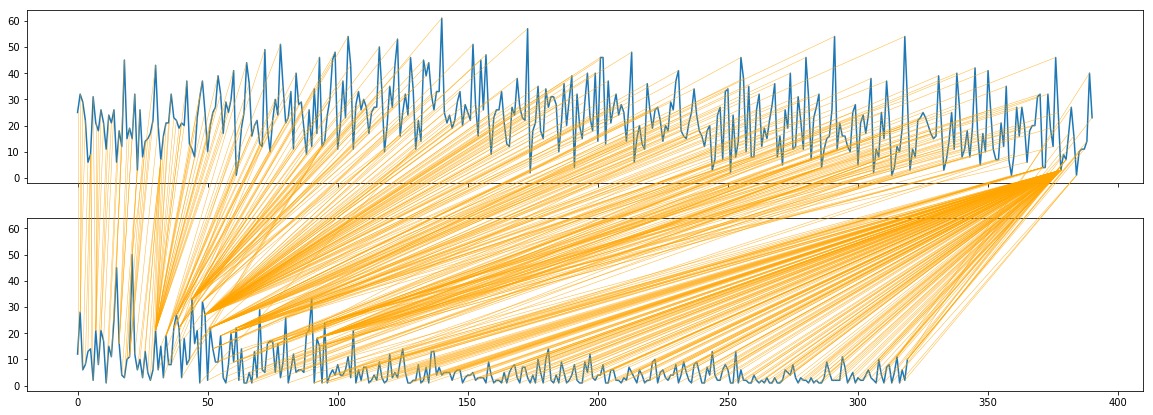

In [6]:
s1 = air_visit_data[
        air_visit_data['air_store_id'] == locations[0]
    ]['visitors'].values

s2 = air_visit_data[
        air_visit_data['air_store_id'] == locations[1]
    ]['visitors'].values

path = dtw.warping_path(s1, s2)
fig, ax = plot_warping(s1, s2, path);
fig.set_size_inches((20, 7))

### Calculate DTW distance matrix

In [23]:
series = air_visit_data.sort_values(['air_store_id', 'visit_date'], ascending=True)[[
    'air_store_id',
    'visitors'
]].groupby('air_store_id').agg(lambda x: list(x)).to_dict(orient='series')['visitors'].values

In [24]:
series = [np.array(s, dtype=np.double) for s in series]

In [28]:
%%time
ds = dtw.distance_matrix_fast(series, max_dist=None, max_length_diff=None)

CPU times: user 2min 22s, sys: 139 ms, total: 2min 22s
Wall time: 2min 22s


In [29]:
ds[ds == np.inf] = 0
ds = ds+ds.T

## Find K medoids

In [33]:
M, C = kmedoids.kMedoids(D=ds, k=3, tmax=100)

### Plot medoids

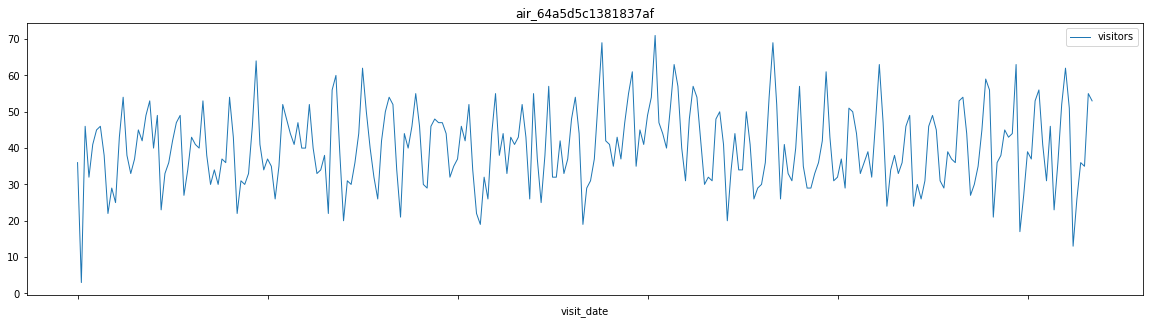

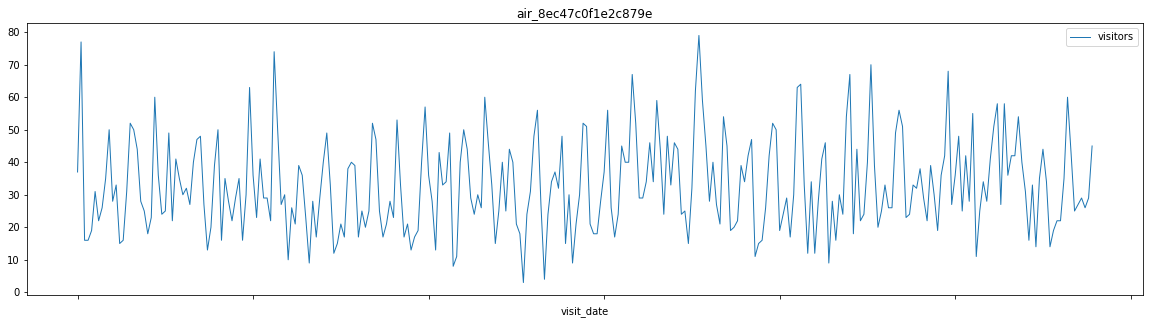

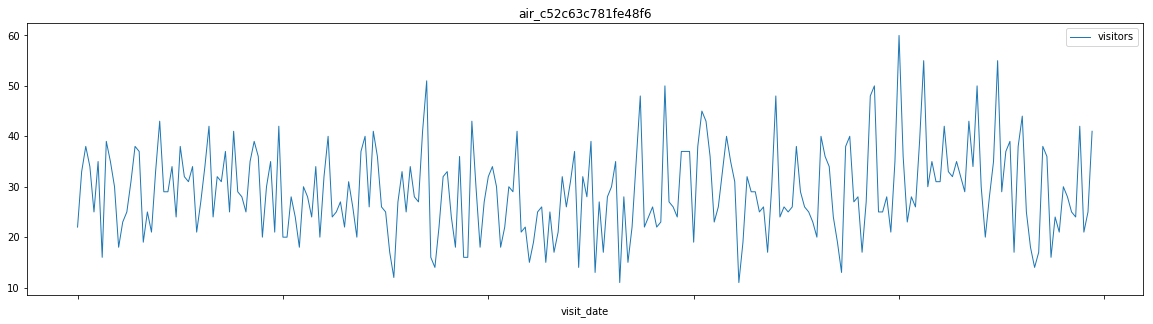

In [42]:
for title, group in air_visit_data[
        air_visit_data['air_store_id'].isin(locations[M])
    ].groupby('air_store_id')[[
        'visit_date',
        'visitors'
    ]]:
    group.plot(
        kind='line',
        lw=1,
        figsize=(20, 5),
        x='visit_date',
        title=title
    );